# Neural Quantum Dynamics Emulator (Part I)

## Introduction

### Scope of this notebook

1. We introduce the basics of quantum dynamic simulations
2. We prepare the raw one-dimensional (1D) quantum dynamics emulation data with space splitting method (SSM).
3. Raw data are resampled into small windows for subsequent training process.
4. Visualize both the raw data and the windows

In [1]:
"""Import libraries"""

# Standard libraries
import collections
import os
import random
import time
import subprocess
import itertools

# Computation Libraries
import numpy as np
import tensorflow as tf

# Graphic libraries
import matplotlib.pyplot as plt
%matplotlib inline

# Custom Libraries
from utils import *

## Section 1: Quantum Dynamics Basics

### 1.1 Wave Funcion
The state of an electron at time t is specified by a complex-valued wave function, $\psi(\overrightarrow{r},t)=Re\psi(\overrightarrow{r},t)+iIm\psi(\overrightarrow{r},t)\in \textbf{C} \ \ (i=\sqrt{-1})$, which is spread in the 3-dimensional space, $\overrightarrow{r}=(x,y,z)\in \textbf{R}^3$. Given the wave function, we can calculate various physical properties such as:


*   $P(\overrightarrow{r},t)=\psi^*(\overrightarrow{r},t)\psi(\overrightarrow{r},t)=|\psi(\overrightarrow{r},t)|^2=|Re\psi(\overrightarrow{r},t)|^2+|Im\psi(\overrightarrow{r},t)|^2$: The probability to find the electron at position $\overrightarrow{r}$ at time $t$.
*   $\langle\overrightarrow{r}(t)\rangle=\int dx\int dy\int dz|\psi(\overrightarrow{r},t)|^2\overrightarrow{r}$:The expected position of the electron at time t.

Here, $\psi^*(\overrightarrow{r},t)$ is the complex conjugate of the wave function.

Normalization: The electron wave function must be normalized such that the electron must be found somewhere in the entire space with probability 1, i.e. 
\begin{equation} 
\int dx\int dy\int dz|\psi(\overrightarrow{r},t)|^2=1 
\tag{1}
\end{equation}

### 1.2 Wave Equation
The time evolution of the electron state, subjected to a time-independent, real-valued potential, $V(\overrightarrow{r})$, is described by the following partial differential equation:
\begin{equation}
i\hbar\frac{\partial}{\partial t}\psi(\overrightarrow{r},t)=[-\frac{\hbar^2}{2m}\nabla^2+V(\overrightarrow{r})]\psi(\overrightarrow{r},t)
\tag{2}
\end{equation}

where $\hbar=1.05457\times 10^{-27} g\cdot cm^2/s$ is the Planck constant, $m=9.10928\times10^{-28}g$ is the electron mass, and $\nabla^2=\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}+\frac{\partial^2}{\partial z^2}$ is the Laplacian operator.

### 1.3 Hartree Atomic Units and Dimensionless Equation
The hartree atomic units are a system of units convenient for microscopic atomic calculations. And we will use this unit system throughout this project. In the following, we measure length $(x, y, z)$ in unit of $\hbar^2/me^2=
0.529177\times 10^{-8} cm$, time $(t)$ in unit of $\hbar^3/me^4=2.41889\times 10^{-17} s$
, and energy $(V)$ in unit of $me^4/\hbar^2=4.35974×10^{-11} g\cdot cm^2/s^2$, where $e = 4.80321×10^{-10}$ esu is the electron charge in the CGS unit. Substituting

\begin{cases}
x=\frac{\hbar^2}{me^2}x', y=\frac{\hbar^2}{me^2}y', z=\frac{\hbar^2}{me^2}z'\\
t=\frac{\hbar^3}{me^4}t'\\
V=\frac{me^4}{\hbar^2}V'
\tag{3}
\end{cases}


in Eq.(2), we obtain the dimensionless equation,

\begin{equation}
i\frac{\partial}{\partial t}\psi(\overrightarrow{r'},t')=[-\frac{\nabla'^2}{2}+V(\overrightarrow{r'})]\psi(\overrightarrow{r'},t')
\tag{4}
\end{equation}

### 1.4 One-dimensional (1D) Case
In our quantum dynamics emulator, we will mainly focus on the time evolution of a wave function in one-dimensional space, $0\leq x\leq L_x$ ($L_x$ is the system size). The one-dimensional wave function, $\psi(r,t)=Re\psi(r,t)+iIm\psi(r,t)\in \textbf{C} \ \ (i=\sqrt{-1})$ satisfies the normalization condition:
\begin{equation}
\int dx|\psi(r,t)|^2=1
\tag{5}
\end{equation}

The time evolution of the wave function, subjected to a time-independent, real-valued potential，$V(x)$ , is described (in the dimensionless form as explained in the lecture note) by the time-dependent
Schrödinger equation:
\begin{equation}
i\frac{\partial}{\partial t}\psi(x,t)=H\psi(x,t)
\tag{6}
\end{equation}
In the above equation. the Hamiltonian operator, $H$, is defined as:
\begin{equation}
H=-\frac{1}{2}\frac{\partial^2}{\partial x^2}+V(x)=T_x+V
\tag{7}
\end{equation}

### 1.5 Periodic Boundary Condition
We impose the periodic boundary condition on the wave function such that
\begin{equation}
\psi(x+L_x)=\psi(x)
\tag{8}
\end{equation}

### 1.6 Space Discretization
For the convenience of computer simulation, the wave function is discretized on a regular mesh of size $\Delta x$. Here $\Delta x=L_x/N_x$ and $N_x$ is the number of mesh points. We denote the discretized wave function as $\psi_j=\psi(j\Delta x)$, where $j=0,1\ ...\ N_x-1$.

In the discretized form, the Hamiltonian operator in Eq. (7) acts as
\begin{equation}
(H\psi)_j=(T_x\psi)_j+(V\psi)_j
\tag{9}
\end{equation}
where
\begin{cases}
(T_x\psi)_j=-\frac{1}{2} \frac{\psi_{j-1}-2\psi_j+\psi_{j+1}}{(\Delta x)^2}\\
(V\psi)_j=V_j\psi_j
\tag{10}
\end{cases}
and the potential energy function is discretized as $V_j=V(j\Delta x)$

### 1.7 Numerical Integration of Schrödinger Equation
The time evolution of the wave function is formally written down as 
\begin{equation}
\psi(t+\Delta t)=exp(-iH\Delta t)\psi(t)
\tag{11}
\end{equation}
the wave function is propagated for a small time interval, Δt, as
\begin{equation}
\psi(t+\Delta t)=exp(-iV\Delta t/2)exp(-iT_x\Delta t)exp(-iV\Delta t/2)\psi(t)+O([\Delta t]^3)
\tag{12}
\end{equation}
In Eq.(12), the application of the potential propagator $exp(-iV\Delta t/2)$ is 
\begin{equation}
(exp(-iV\Delta t/2)\psi)_j=exp(-iV_j\Delta t/2)\psi_j
\tag{13}
\end{equation}

To apply the kinetic propagator, $exp(-iT_x\Delta t)$, we use the space-splitting method (SSM). To
understand the SSM, we first note that the operation of $T_x$ on $\psi_j$ is expressed as 
\begin{equation}
T_x\psi_j=b\psi_{j-1}+2a\psi_j+b\psi_{j+1}
\tag{14}
\end{equation}
where 
\begin{cases}
a=1/2(\Delta x)^2\\
b=-1/2(\Delta x)^2
\tag{15}
\end{cases}
The operation of $T_x$ on $\psi_j$ thus amounts to the multiplication of a tridiagonal matrix,
\begin{equation}
T_x=
\begin{bmatrix}
2a&b&&&&&b\\
b&2a&b\\
&b&2a&b\\
&&\ddots&\ddots&\ddots\\
&&&b&2a&b\\
&&&&b&2a&b\\
b&&&&&b&2a\\
\end{bmatrix}
\tag{16}
\end{equation}
In the SSM, the tridiagonal matrix is expressed as a direct sum of $2\times 2$ submatrices,
\begin{equation}
T_x=\frac{1}{2}
\begin{bmatrix}
a&b&\\
b&a\\
&&a&b\\
&&b&a\\
&&&&\ddots\\
&&&&&a&b\\
&&&&&b&a\\
\end{bmatrix}
+
\begin{bmatrix}
a&&&&&&b\\
&a&b\\
&b&a\\
&&&\ddots\\
&&&&a&b\\
&&&&b&a\\
b&&&&&&a\\
\end{bmatrix}
+\frac{1}{2}
\begin{bmatrix}
a&b&\\
b&a\\
&&a&b\\
&&b&a\\
&&&&\ddots\\
&&&&&a&b\\
&&&&&b&a\\
\end{bmatrix}
\tag{17}
\end{equation}
The exponential of $T_x$ is calculated analytically as follows:
\begin{equation}
exp(-i\Delta tT_x)=U_x^{(half)}U_x^{(full)}U_x^{(half)}+O((\Delta t)^3)
\tag{18}
\end{equation}
where
\begin{cases}
U_x^{(half)}=
\begin{bmatrix}
\epsilon_2^+&\epsilon_2^-&\\
\epsilon_2^-&\epsilon_2^+\\
&&\epsilon_2^+&\epsilon_2^-\\
&&\epsilon_2^-&\epsilon_2^+\\
&&&&\ddots\\
&&&&&\epsilon_2^+&\epsilon_2^-\\
&&&&&\epsilon_2^-&\epsilon_2^+\\
\end{bmatrix}
\\
U_x^{(full)}=
\begin{bmatrix}
\epsilon_1^+&&&&&&\epsilon_1^-\\
&\epsilon_1^+&\epsilon_1^-\\
&\epsilon_1^-&\epsilon_1^+\\
&&&\ddots\\
&&&&\epsilon_1^+&\epsilon_1^-\\
&&&&\epsilon_1^-&\epsilon_1^+\\
\epsilon_1^-&&&&&&\epsilon_1^+\\
\end{bmatrix}
\tag{19}
\end{cases}
with
\begin{cases}
\epsilon_n^+=\frac{1}{2}[exp(-\frac{i\Delta t}{n}(a+b))+exp(-\frac{i\Delta t}{n}(a-b))]\\
\epsilon_n^-=\frac{1}{2}[exp(-\frac{i\Delta t}{n}(a+b))-exp(-\frac{i\Delta t}{n}(a-b))]
\tag{20}
\end{cases}



## Section 2: Input Data

We prepare the raw one-dimensional (1D) quantum dynamics emulation data with space splitting method (SSM). The Hartree atomic units are used through the emulations.

### 2.1 SSM Parameters
Here are a few important parameters that are used during SSM emulations.

| parameter | description                                      |
|:---------:|:------------------------------------------------ |
| `NX`,`LX`| The wave function is discretized on a regular mesh of size $\Delta x$ = `LX`/`NX` where `NX` is the number of mesh points and `LX` is the length of the simulation box.  |
| `DT`  | Time discretization unit     |
| `X0`,`S0`,`E0` | Center-of-mass, spread and energy of initial gaussian-modulated wave packet              |
| `BH`,`BW`  | Rectangular barrier height and width centered at the simulation box. |

By default, we set `LX=100`, `NX=1024` and `DT=0.0005` for SSM simulations. However, we intentionally only keep the first frame from every 200 frames when we export the raw emulation results. That means for the subsequent data (for neural emulator) `DT=0.01`.

### 2.2 Training Data
We generate training dataset with a two-step manner. In the first step, we generate raw simulation data with SSM method. In the second step, we resample the raw data for future training process and store them into tfrecord format to speed up training.

#### First Step: Raw emulations
We generate the raw emulation data with ```simulator/quantum_wave_packets/simulator.c``` and ```simulator/quantum_wave_packets/simulator.h```. 

In [2]:
"""Compile the SSM emulation code"""
!gcc -O -o ../simulator/quantum_wave_packets/simulator.x ../simulator/quantum_wave_packets/simulator.c -lm

In [3]:
"""Raw data generation settings"""

# Raw data directory
base_dir = "../datasets/demo" #for generating full dataset use "../datasets/full"
raw_dir = os.path.join(base_dir, "raw")

# Parameter lists
# The data generation process will generate the raw emulation data for each parameter combination.
X0_list = [10.0, 40.0, 70.0]
S0_list = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
E0_list = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
BH_list = [2.0, 5.0, 10.0]
BW_list = [7.0]
EH_list = [0.0]

# To generate full dataset use:
# X0_list = [10.0, 40.0, 70.0]
# S0_list = list(np.arange(1.0, 4.1, 0.5))
# E0_list = list(np.arange(1.0, 9.1, 1.0))
# BH_list = list(np.arange(1.0, 14.1, 1.0))
# BW_list = [7.0]
# EH_list = [0.0]

#Create directories if they don't exist
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
if not os.path.exists(raw_dir):
    os.makedirs(raw_dir)

In [4]:
def write_raw_files():
    """A single process creating and writing out 1D quantum dynamic raw simulation results."""
 
    #Keep track of time
    start_time = time.time()
    
    #All permutations of examples
    examples = list(itertools.product(X0_list, S0_list, E0_list, BH_list, BW_list, EH_list))
    total = len(examples)
    
    print("Writing raw simulation results...")
    #Calculate simulations for all examples and save them on disk
    for i,example in enumerate(examples):

        #Convert to strings
        (X0, S0, E0, BH, BW, EH) = tuple(map(str,example))
        
        #Calculate and save simulation
        result = subprocess.call(['../code/data/qd1', X0, S0, E0, BH, BW, EH, raw_dir + "/" +
                                  '_'.join([X0, S0, E0, BH, BW, EH]) + '.txt'], stdout=subprocess.PIPE)
        
        #Print Time and Status
        elapsed = time.time() - start_time
        print("Processed {:}/{:} Files ({:.1f}%), ELAPSED: {:}, ETA: {:}".format(
            i+1, total, 100.0 * (i+1) / total,
            get_readable_time(elapsed),
            get_readable_time(int((total - i+1) / ((i+1) / elapsed)))
        ))
        
    print("Raw files saved successfully!")

# Raw data generation
write_raw_files()

Writing raw simulation results...
Processed 1/567 Files (0.2%), ELAPSED:  0h 0m 2s, ETA:  0h23m 8s
Processed 2/567 Files (0.4%), ELAPSED:  0h 0m 4s, ETA:  0h23m19s
Processed 3/567 Files (0.5%), ELAPSED:  0h 0m 7s, ETA:  0h23m39s
Processed 4/567 Files (0.7%), ELAPSED:  0h 0m 9s, ETA:  0h23m29s
Processed 5/567 Files (0.9%), ELAPSED:  0h 0m12s, ETA:  0h23m18s
(...)
Processed 563/567 Files (99.3%), ELAPSED:  0h23m14s, ETA:  0h 0m14s
Processed 564/567 Files (99.5%), ELAPSED:  0h23m16s, ETA:  0h 0m12s
Processed 565/567 Files (99.6%), ELAPSED:  0h23m18s, ETA:  0h 0m 9s
Processed 566/567 Files (99.8%), ELAPSED:  0h23m21s, ETA:  0h 0m 7s
Processed 567/567 Files (100.0%), ELAPSED:  0h23m23s, ETA:  0h 0m 4s
Raw files saved successfully!


#### Visualize Raw Simulation Data

Text(0.5, 1.0, 'Im (Psi)')

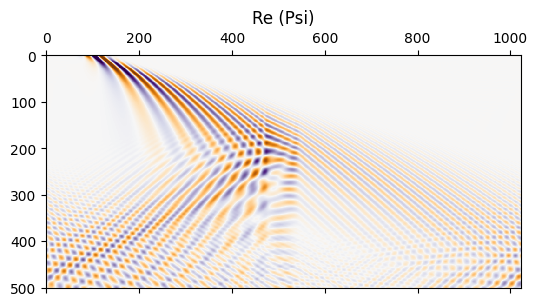

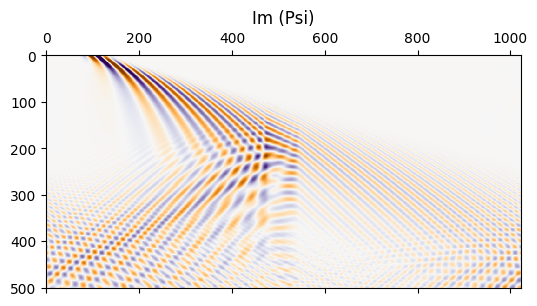

In [5]:
plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':100})
plt.style.use('seaborn-pastel')

data = retrieve_data("../datasets/demo/raw/10.0_1.0_2.0_2.0_7.0_0.0.txt", 10.0)

plt.matshow(data["psi_re"], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title('Re (Psi)')
plt.matshow(data["psi_im"], vmax=0.4, vmin=-0.4, cmap="PuOr")
plt.title('Im (Psi)')

#### Second Step: Data windowing

In the next notebook, we are going to introduce sliding-window based models. As a result, we resample the raw data during the second step to slice whole simulation box into smaller windows. Each window contains few frames of three-channel information, i.e. real and imaginary part of wavefuncions and potential values. We are about to use the first N-1 frames to predict the last frame for each window.

There are a few rules we are using to optimize the training results:
1. We use spatial and temporal sampling ratio to intentionally skip some windows.
2. We want to put more attention to the windows which are overlapped with the center potential barrier. Thus we assign a higher possibility to sample those windows compare to windows with zero potential. 
3. We extend the left pixels of the simulation box to the right before sampling in order to acommandate the periodic boundary condition.
4. The potential values are rescaled to [0, 1].

In [6]:
"""Tfrecord data windowing settings"""

# Tfrecords data folder
tfrecords_dir = os.path.join(base_dir, "tfrecords")

# Number of output tfrecord files
num_out_files = 100  # 1000 for full dataset

# Number of input frames
num_input_frames = 4

# Window size
window_size = 23

# Randomness seed
seed = 1314

# Temporal and spatial sampling ratio
temp_ratio = 0.9
spat_ratio = 0.1

# The probability associated with the windows overlapped with the center potential barrier
barrier_sample_weight = 50.

# Divide all potential values by pot_scalar
pot_scalar = 10.0  #14.0 for full dataset

if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir)

In [7]:
def create_float_feature(values):
    """ Convert list of float values to tf train Feature"""
    return tf.train.Feature(float_list=tf.train.FloatList(value=values))

class ExampleWriter(object):
    """Writes pre-training examples to disk."""
    
    def __init__(self, output_dir, num_out_files=100):
        """Initialize ExampleWrite Object"""
        self._writers = []
        for i in range(num_out_files):
            output_fname = os.path.join(output_dir, "qdml.tfrecord-{:}-of-{:}".format(i, num_out_files))
            self._writers.append(tf.io.TFRecordWriter(output_fname))
        self.n_written = 0
    
    
    def example_generator(self, data):
        """Takes in a raw file and converts it into tfrecords"""
        
        features = np.stack([data["psi_re"], data["psi_im"], data["pot"]], axis=-1)
        L = len(data["pot"][0])
        
        #Satisfying Boundary Condition
        features = np.hstack((features, features[:, :window_size, :]))
        
        #Temporal Sample Indices
        temp_sample = np.random.choice(features.shape[0] - num_input_frames - 1,
                                       int((features.shape[0] - num_input_frames - 1) * temp_ratio),
                                       replace=False
                                      )
        
        #Indices where potential exists
        v_tmp = np.where(data["pot"][0] != data["pot"][0][0])[0]
        v_start, v_end = v_tmp[[0, -1]] if len(v_tmp) > 1 else (-1, -1)
        
        
        #Spatial Sampling Probabilities
        spat_sample_ratio = np.ones(L)
        if v_start > -1:
            spat_sample_ratio[np.arange(v_start - window_size + 1, v_end + 1)] = barrier_sample_weight
        spat_sample_ratio /= spat_sample_ratio.sum()
        
        #Create Windows from Temporal and Spatial Sampled Indices
        for i in temp_sample:
            spat_sample = np.random.choice(L, int(L * spat_ratio), p=spat_sample_ratio, replace=False)
            for j in spat_sample:
                #Create tf examples from a set of windows
                tf_example = tf.train.Example(
                    features=tf.train.Features(
                        feature={
                            "feature":create_float_feature(features[i:i+num_input_frames+1, j:j+window_size].reshape(-1))
                        }
                    )
                )
                yield tf_example
        return

    def write_examples(self, input_file):
        """Writes out examples from the provided input file."""
        
        data = collections.defaultdict(list)
        
        #Read from raw file and fill data
        with tf.io.gfile.GFile(input_file) as f:
            for line in f:
                for key in ["timestamp", "params", "psi_re", "psi_im", "pot"]:
                    if line.startswith(key):
                        data[key].append([float(x) for x in line.split()[1:]]
                                         if key != "timestamp" else float(line.split()[1]))
        
        #Convert each list to numpy array
        for key in ["timestamp", "params", "psi_re", "psi_im", "pot"]:
            data[key] = np.array(data[key])
            
        #Normalize Potential Values
        data["pot"] /= pot_scalar
        
        #Generate training features and write to disk
        example_iterator = iter(self.example_generator(data))
        for example in example_iterator:
            self._writers[self.n_written % len(self._writers)].write(example.SerializeToString())
            self.n_written += 1

    def finish(self):
        """ Close all TfRecordWriters"""
        for writer in self._writers:
            writer.close()
            
            

def write_tfrecords():
    """A single process creating and writing out pre-processed examples."""

    print("Creating example writer")
    example_writer = ExampleWriter(output_dir = tfrecords_dir, num_out_files=num_out_files)
    
    print("Writing tf examples")
    
    #Load Raw File Names
    fnames = sorted(tf.io.gfile.listdir(raw_dir))
    random.shuffle(fnames)
    
    #Keep Track of Time
    start_time = time.time()
    
    for file_no, fname in enumerate(fnames):
        #Keep track of information
        if file_no > 0:
            elapsed = time.time() - start_time
            print("Processed {:}/{:} files ({:.1f}%), ELAPSED: {:}s, ETA: {:}s, {:} examples written".format(
                file_no, len(fnames),
                100.0 * file_no / len(fnames),
                get_readable_time(elapsed),
                get_readable_time((len(fnames) - file_no) / (file_no / elapsed)),
                example_writer.n_written
                )
            )
        
        #Write examples to disk
        example_writer.write_examples(os.path.join(raw_dir, fname))
    
    example_writer.finish()
    print("Done!")

# Transform raw emulation files into tfrecords
write_tfrecords()

Creating example writer
Writing tf examples
Processed 1/567 files (0.2%), ELAPSED:  0h 0m 4ss, ETA:  0h44m21ss, 45492 examples written
Processed 2/567 files (0.4%), ELAPSED:  0h 0m 9ss, ETA:  0h43m30ss, 90984 examples written
Processed 3/567 files (0.5%), ELAPSED:  0h 0m14ss, ETA:  0h44m 1ss, 136476 examples written
Processed 4/567 files (0.7%), ELAPSED:  0h 0m18ss, ETA:  0h43m49ss, 181968 examples written
Processed 5/567 files (0.9%), ELAPSED:  0h 0m23ss, ETA:  0h43m31ss, 227460 examples written
(...)
Processed 562/567 files (99.1%), ELAPSED:  1h22m39ss, ETA:  0h 0m44ss, 25566504 examples written
Processed 563/567 files (99.3%), ELAPSED:  1h22m52ss, ETA:  0h 0m35ss, 25611996 examples written
Processed 564/567 files (99.5%), ELAPSED:  1h23m 3ss, ETA:  0h 0m26ss, 25657488 examples written
Processed 565/567 files (99.6%), ELAPSED:  1h23m13ss, ETA:  0h 0m17ss, 25702980 examples written
Processed 566/567 files (99.8%), ELAPSED:  1h23m25ss, ETA:  0h 0m 8ss, 25748472 examples written
Done!


#### Visualize Data Windows

In [11]:
config = Config()
dataset = iter(get_dataset(config))

All shapes are: (Batch, (Time_steps,) Window_size, Channels)
Inputs shape: (128, 4, 23, 3)
labels shape: (128, 23, 2)


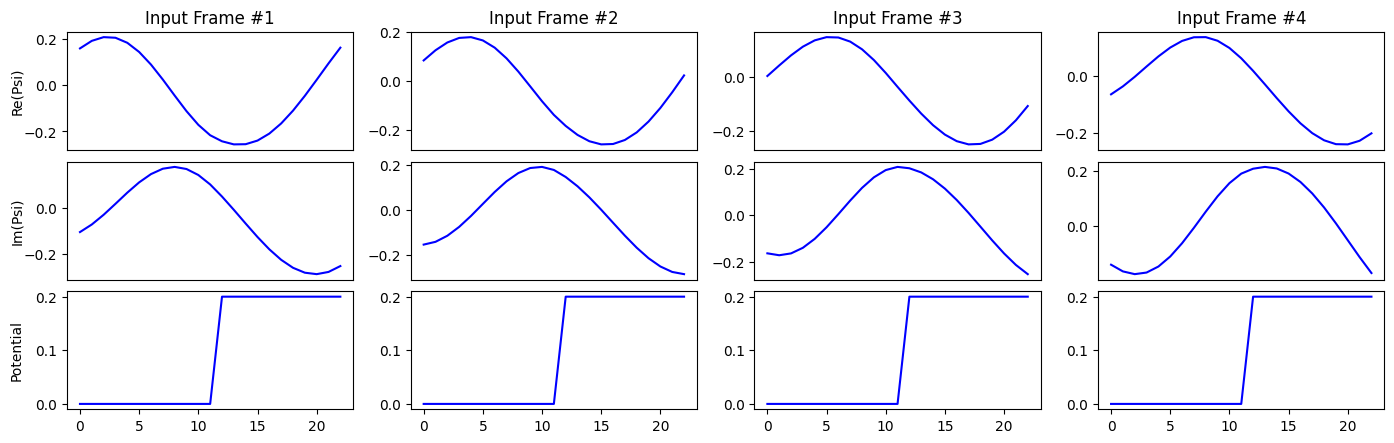

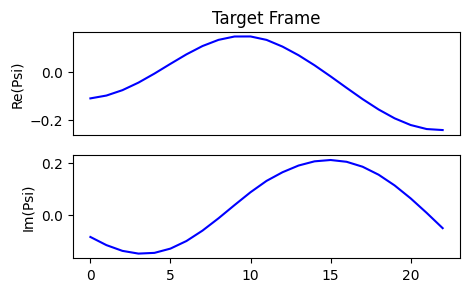

In [13]:
def plot_windows(config, feature, target):
    """ For any feature and target, plot all input frames and target frame"""
    plt.style.use('seaborn-pastel')
    ylabel = ["Re(Psi)", "Im(Psi)", "Potential"]
    
    #Plot the input frames
    fig = plt.figure(figsize=(17, 5))
    outer = gridspec.GridSpec(1, config.input_frames)
    
    for i in range(config.input_frames):
        inner = gridspec.GridSpecFromSubplotSpec(config.input_channels, 1, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
        for j in range(config.input_channels):
            ax = plt.Subplot(fig, inner[j])
            y = feature[i, :, j]
            ax.plot(y, c="blue")
            if j == 0:
                ax.set_title(f"Input Frame #{i+1}")
            if j != 2:
                ax.set_xticks([])
            if i == 0:
                ax.set_ylabel(ylabel[j])
                ax.yaxis.set_label_coords(-0.15, 0.5)
            fig.add_subplot(ax)
    
    #Plot the target frame
    fig2 = plt.figure()
    label = gridspec.GridSpec(config.output_channels,1)
    for i in range(2):
        ax = plt.Subplot(fig2,label[i])
        ax.plot(target[:,i],c='blue')
        ax.set_ylabel(ylabel[i])
        if i==0:
            ax.set_title("Target Frame")
            ax.set_xticks([])
        fig2.add_subplot(ax)

batch_feature, batch_target = next(dataset)
print('All shapes are: (Batch, (Time_steps,) Window_size, Channels)')
print(f'Inputs shape: {batch_feature.shape}')
print(f'labels shape: {batch_target.shape}')
plot_windows(config, batch_feature[2], batch_target[2])